In [15]:
import json
import os

# Mathematical functions; high-performance data structures
import numpy as np
import pandas as pd
pd.options.display.max_columns=13

# Data standardization
from sklearn.preprocessing import StandardScaler

# Principal Component Analysis
from sklearn.decomposition import PCA

# k-Means Clustering
from sklearn.cluster import KMeans

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

* Alex Hahn
* INF 552: Machine Learning for Data Science
* November 4, 2019

# **Clustering Yelp Users**

## 0.1 The Yelp Open Dataset

The Yelp Open Dataset is a subset of businesses, reviews, and user data from the Yelp platform. It is made available to the public for "personal, educational, and academic purposes." The dataset includes, roughly: 1.6M users, 6.7M reviews, 1.2M tips, 200K businesses, 200K photos, .... For this analysis, the Yelp Dataset was accessed via [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset).

## 0.2 Introduction

The goal of this data experiment is to explore whether there are identifiable sub-groups within the Yelp community. If so, what are distinguishing characteristics that can separate users? And, what insights can we gain from, or about, these groups?  
  
In this analysis we perform the following steps...  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1. Load the dataset  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2. Preprocess  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. Standardize  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4. Apply PCA  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5. Apply clustering  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6. Report results  


## 1.1 Load the 'User' dataset

The dataset is hosted on Kaggle, and can be accessed directly via the Kaggle kernel. This notebook was developed using the Kaggle kernel, and refers to dataset files in the Kaggle file system. 

The dataset is also available to download (~8GB) if this notebook needs to be run locally; just update the filepaths in the two cells below.

In [16]:
# List the datasets that are available
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/Dataset_Challenge_Dataset_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json


In [17]:
# Only use the first 100,000 entries for this analysis.
users = []
with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json') as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i+1 >= 100000:
            break
users_df = pd.DataFrame(users)
users_df.head()

,user_id,name,review_count,yelping_since,useful,funny,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,...,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,...,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,...,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,...,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,...,16,57,80,80,25,5


## 1.2 What's in the dataset?

What are the dimensions of the table? (num samples, num attributes)

In [18]:
users_df.shape

(100000, 22)

What attributes are recorded for each user? What data types are they?

In [19]:
users_df.dtypes

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

Get descriptive statistics for numerical attributes

In [20]:
users_df.describe().round(2)

,review_count,useful,funny,cool,fans,average_stars,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,...,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,82.56,211.55,104.44,133.01,7.15,3.80,...,8.14,18.55,18.77,18.77,7.09,7.26
std,201.29,1353.68,941.57,1149.30,38.51,0.73,...,78.64,215.65,214.51,214.51,80.52,188.02
min,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,6.00,1.00,1.00,0.00,3.45,...,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.00,23.00,5.00,6.00,1.00,3.86,...,0.00,0.00,0.00,0.00,0.00,0.00
75%,71.00,85.00,23.00,27.00,3.00,4.25,...,2.00,2.00,2.00,2.00,1.00,0.00
max,12390.00,89792.00,86122.00,83915.00,2964.00,5.00,...,7579.00,14888.00,19348.00,19348.00,8341.00,39055.00


## 2.1 Preprocessing — Feature Elimination + Feature Engineering

Prepare the data for analysis. Start by removing some unnecessary columns (`name` and `user_id`). Then, engineer some new features that may be interesting. For example, number of friends, number of years with Elite status, velocity of posts, etc. 

In [21]:
# Eliminate some columns that are not helpful for this analysis
users_df.drop(['user_id', 'name'], axis=1, inplace=True)

# Count each user's number of friends
users_df['num_friends'] = users_df['friends'].apply(lambda x: len(x.split(', ')) if (len(x) != 0) else 0)
users_df.drop(['friends'], axis=1, inplace=True)

# Count the number of years each user has been Elite
users_df['years_elite'] = users_df['elite'].apply(lambda x: len(x.split(',')) if (len(x) != 0) else 0)
users_df.drop(['elite'], axis=1, inplace=True)

# Count the total number of feedback for each user (feedback is for user reviews)
users_df['num_feedback'] = np.sum(users_df[['useful', 'funny', 'cool']], axis=1)

# Count the total number of compliments for each user (compliments are for users themselves)
users_df['num_compliments'] = users_df.loc[:, users_df.columns.str.startswith('compliment_')].sum(axis=1)
compliment_cols = [col for col in users_df.columns if 'compliment_' in col]
users_df.drop(compliment_cols, axis=1, inplace=True)

# Calculate the number of years the user has been Yelping
users_df['years_yelping'] = pd.Timestamp.now() - pd.to_datetime(users_df['yelping_since'])
users_df['years_yelping'] = users_df['years_yelping'].apply(lambda x: x.days)
users_df['years_yelping'] = users_df['years_yelping'] / 365.0
users_df.drop(['yelping_since'], axis=1, inplace=True)

# Calculate the velocity that the user posts reviews (reviews-per-year)
users_df['review_velocity'] = users_df['review_count'] / users_df['years_yelping']

# Calculate the average quality of each user's reviews (feedback-per-review)
users_df['review_quality'] = users_df['num_feedback'] / users_df['review_count']

users_df.round(2).head()

,review_count,useful,funny,cool,fans,average_stars,num_friends,years_elite,num_feedback,num_compliments,years_yelping,review_velocity,review_quality
0,95,84,17,25,5,4.03,99,3,126,8,6.07,15.64,1.33
1,33,48,22,16,4,3.63,1152,0,86,3,6.70,4.92,2.61
2,16,28,8,10,0,3.71,15,0,46,1,6.09,2.63,2.88
3,17,30,4,14,5,4.85,525,0,48,4,5.45,3.12,2.82
4,361,1114,279,665,39,4.08,231,4,2058,293,6.04,59.81,5.70


In [22]:
users_df.describe().loc[['mean', 'std', 'min', 'max']].round(2)

,review_count,useful,funny,cool,fans,average_stars,num_friends,years_elite,num_feedback,num_compliments,years_yelping,review_velocity,review_quality
mean,82.56,211.55,104.44,133.01,7.15,3.80,111.70,0.70,449.00,96.82,7.11,10.39,2.25
std,201.29,1353.68,941.57,1149.30,38.51,0.73,285.78,1.75,3421.55,1171.67,2.48,22.09,3.92
min,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.46,0.00,0.00
max,12390.00,89792.00,86122.00,83915.00,2964.00,5.00,9564.00,13.00,257668.00,134360.00,15.07,1368.34,196.19


## 2.2 Preprocessing — Log Transformation

Some of the columns need to be scaled. There are big differences between the value ranges of many features. For example, `review_count` has a range between 0 and 12,390. This is **much** higher than the `average_stars` range of 1 to 5. These discrepancies in scale would cause problems with clustering later on.

Let's apply a logarithmic function to these columns to scale their ranges appropriately.

In [23]:
transform_cols = []
for i in range(users_df.shape[1]):
    if users_df.iloc[:, i].max() > 20:
        transform_cols.append(users_df.iloc[:, i].name)

transform_cols

['review_count',
 'useful',
 'funny',
 'cool',
 'fans',
 'num_friends',
 'num_feedback',
 'num_compliments',
 'review_velocity',
 'review_quality']

In [24]:
for col in transform_cols:
    users_df[col] = users_df[col].apply(lambda x: 0 if x == 0 else np.log10(x))
    
users_df.round(2).head()

,review_count,useful,funny,cool,fans,average_stars,num_friends,years_elite,num_feedback,num_compliments,years_yelping,review_velocity,review_quality
0,1.98,1.92,1.23,1.40,0.70,4.03,2.00,3,2.10,0.90,6.07,1.19,0.12
1,1.52,1.68,1.34,1.20,0.60,3.63,3.06,0,1.93,0.48,6.70,0.69,0.42
2,1.20,1.45,0.90,1.00,0.00,3.71,1.18,0,1.66,0.00,6.09,0.42,0.46
3,1.23,1.48,0.60,1.15,0.70,4.85,2.72,0,1.68,0.60,5.45,0.49,0.45
4,2.56,3.05,2.45,2.82,1.59,4.08,2.36,4,3.31,2.47,6.04,1.78,0.76


In [25]:
users_df.describe().loc[['mean', 'std', 'min', 'max']].round(2)

,review_count,useful,funny,cool,fans,average_stars,num_friends,years_elite,num_feedback,num_compliments,years_yelping,review_velocity,review_quality
mean,1.40,1.37,0.84,0.91,0.31,3.80,1.48,0.70,1.56,0.61,7.11,0.58,0.17
std,0.67,0.86,0.84,0.86,0.51,0.73,0.77,1.75,0.91,0.80,2.48,0.61,0.39
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.46,-1.12,-1.72
max,4.09,4.95,4.94,4.92,3.47,5.00,3.98,13.00,5.41,5.13,15.07,3.14,2.29


Much better; the ranges of the attributes are all within reasonable, similar bounds. 

## 3. Standardization

Now that the data is preprocessed, next we have to standardize it in order to be compatible with Principal Component Analysis (PCA). Standardization is used to transform attributes so they have mean=0 and standard deviation=1.

Note: Next in section 4, we'll find that `useful`, `funny`, and `cool` are the only features worth grouping for PCA in this analysis. So, let's only standardize these three columns, the rest we'll leave alone. The plots toward the end of the notebook look better with non-standardized data.

In [26]:
# Standardize the data to prepare for PCA
standardize_cols = ['useful', 'funny', 'cool']
for col in standardize_cols:
    users_df[col] = StandardScaler().fit_transform(np.array(users_df[col]).reshape(-1, 1))

users_df[standardize_cols].describe().loc[['mean', 'std', 'min', 'max']].round(2)

,useful,funny,cool
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-1.59,-1.01,-1.05
max,4.17,4.89,4.66


## 4.1 PCA — Correlation Heatmap

Principal Component Analysis is a technique for dimensionality reduction. It works by taking a group of attributes and extracting/reducing principal components. It takes the most significant samples in each column, and combines them such that the first principal component has the highest possible variance (i.e. explains as much of the data's variability as possible). 
  
PCA works best on attributes that are related, so let's look at attribute correlations to figure that out. The heatmap below shows which attributes are correlated, and how strongly.

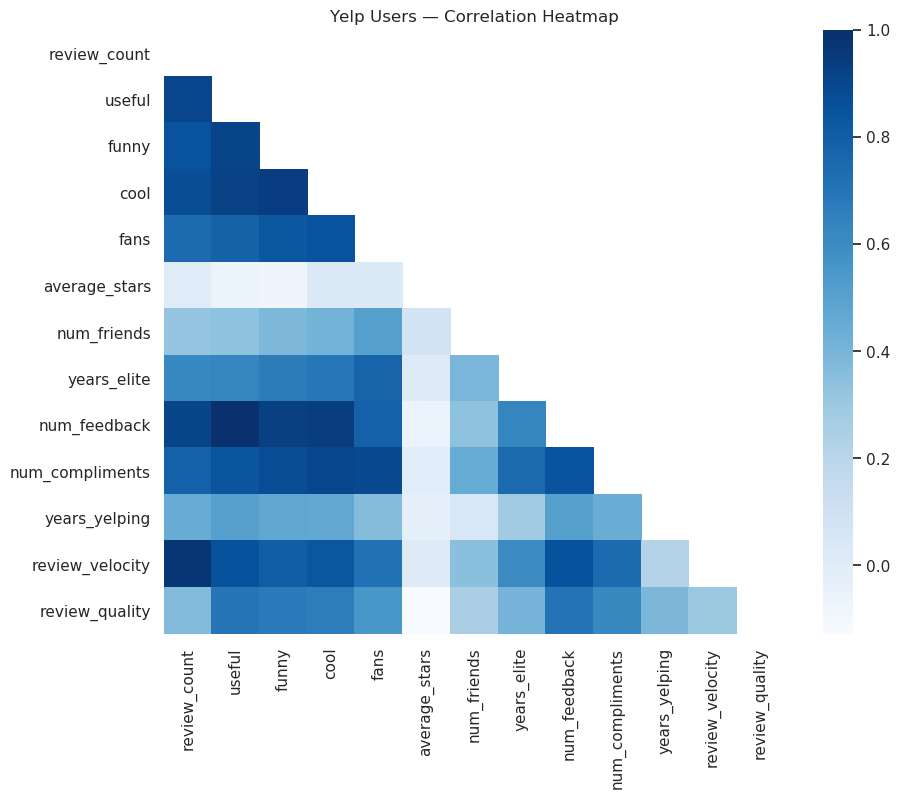

In [27]:
# Calculate the correlation matrix
corr = users_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create a heatmap from the correlation data
sns.set(style='white')
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
sns.heatmap(corr, mask=mask, cmap='Blues')
plt.title('Yelp Users — Correlation Heatmap')
plt.show()

Based on the heatmap, it looks like `useful`, `funny`, and `cool` would be good attributes to group for PCA. These features are highly-correlated, so it makes sense to reduce them to a principal component.

## 4.2 PCA — Apply PCA to the chosen features

Combine the feedback columns. Its principal component represents the number of times a user's reviews have been voted useful, funny, or cool.

In [28]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)

pca_cols = ['useful', 'funny', 'cool']
principal_component = pca.fit_transform(users_df[pca_cols])
users_df['feedback_factor'] = principal_component
users_df.drop(pca_cols, axis=1, inplace=True)

users_df.round(2).head()

,review_count,fans,average_stars,num_friends,years_elite,num_feedback,num_compliments,years_yelping,review_velocity,review_quality,feedback_factor
0,1.98,0.70,4.03,2.00,3,2.10,0.90,6.07,1.19,0.12,0.97
1,1.52,0.60,3.63,3.06,0,1.93,0.48,6.70,0.69,0.42,0.75
2,1.20,0.00,3.71,1.18,0,1.66,0.00,6.09,0.42,0.46,0.16
3,1.23,0.70,4.85,2.72,0,1.68,0.60,5.45,0.49,0.45,0.07
4,2.56,1.59,4.08,2.36,4,3.31,2.47,6.04,1.78,0.76,3.52


## 5.1 Clustering — Pair Plot
Before clustering users, we first need to determine which features to use for learning. Let's start by looking at a pair plot. This helps us better understand the relationships between features.

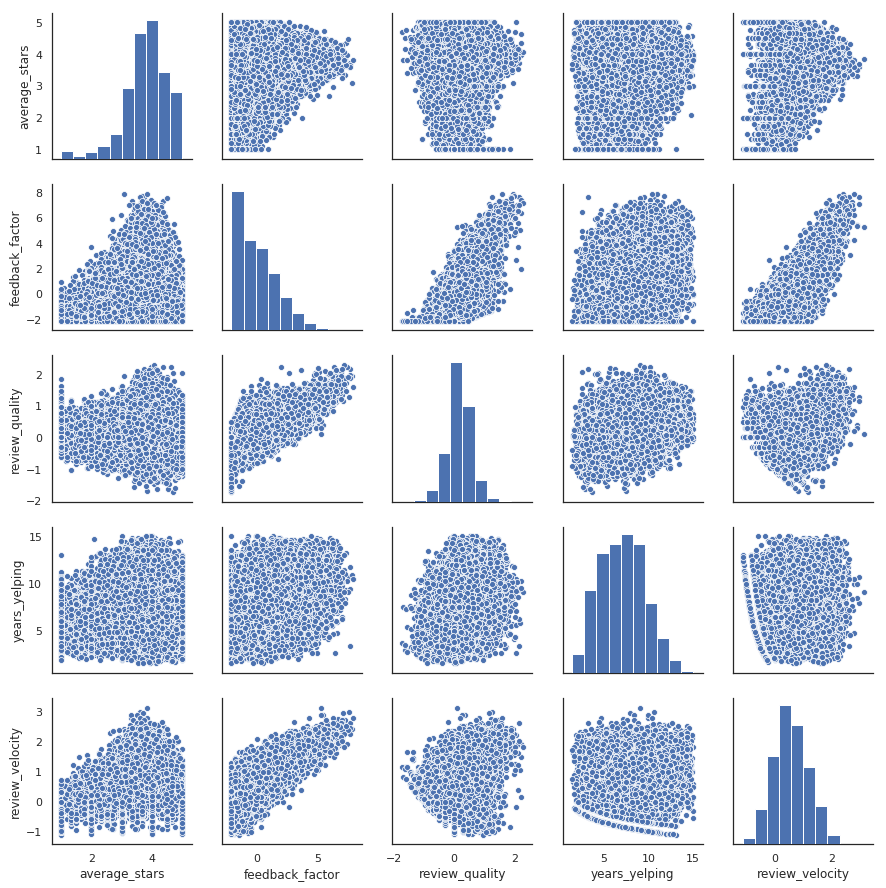

In [30]:
interest_cols = ['average_stars', 'feedback_factor', 'review_quality', 'years_yelping', 'review_velocity']
sns.pairplot(users_df[interest_cols])
plt.show()

Besed on the pair plot, it looks like `review_velocity` and `average_stars` could be interesting for clustering. It appears that there is a positive relationship between these attributes.

## 5.2 Clustering — Apply k-Means to the data

k-Means is a clustering algorithm which categorizes a dataset into `n_cluster` number of groups. You tell the algorithm how many clusters (you think) are in the dataset, and it figures out where those clusters are and assigns every point to one of them. It can also make predictions by taking unseen points and assigning them to learned clusters. 

It is an unsupervised learning algorithm. So, training data samples only contain input attributes, no response labels. The algorithm learns a centroid (the center/mean) for each cluster. Then, it assigns each point to a cluster represented by that point's nearest centroid. The model gives us a set of labels — the cluster numbers that each user belongs to — but can't tell us anything about a cluster itself; for example, its name. In the Report section below, I named these four clusters based on characteristics of each user type.

In [31]:
# Apply clustering to the data
kmeans = KMeans(n_clusters=4).fit(users_df[['review_velocity', 'average_stars']])

# Add cluster numbers to the dataset. The model assigned each training row to a cluster
users_df['cluster'] = kmeans.labels_

# Get the cluster centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=['c1', 'c2'])

Plot the clusters and centroids. Each point is a user, they are colored based on the cluster that the kMeans model assigned.

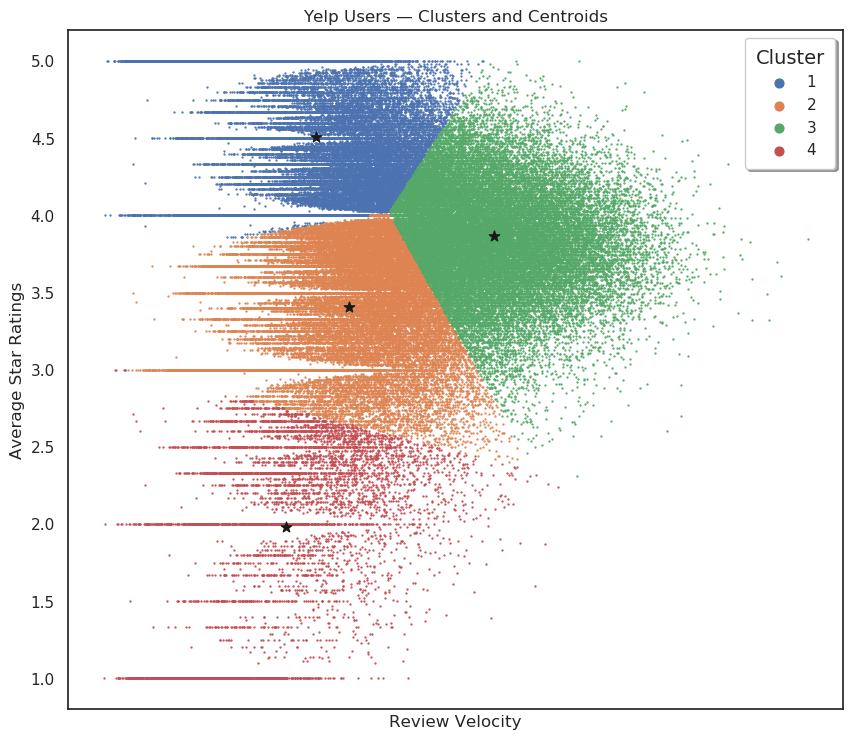

In [34]:
plt.figure(figsize=(10, 9), dpi=100)

cluster_set = set(list(users_df['cluster']))
clusters_grouped = users_df.groupby('cluster')
for cluster in cluster_set:
    cluster_df = clusters_grouped.get_group(cluster)
    plt.scatter(x=cluster_df['review_velocity'], y=cluster_df['average_stars'], c=f'C{cluster}', s=0.4, label=int(cluster)+1)
plt.legend(title='Cluster', shadow=True, markerscale=10, borderpad=0.7, title_fontsize=14)

plt.scatter(centroids_df['c1'], centroids_df['c2'], c='k', marker='*', s=60, label='Centroid')

plt.xticks([])
plt.xlabel('Review Velocity')
plt.ylabel('Average Star Ratings')
plt.title('Yelp Users — Clusters and Centroids')
plt.show()

### Does Elite status somehow relate to these clusters?

I'm curious how Elite status relates to the learned clusters. Are there particular clusters that have more Elite members? Or, are Elite members distributed throughout all 4 clusters?

Let's make the same plot again, but this time differentiate the users who have had Elite status at least once. They are marked in black.

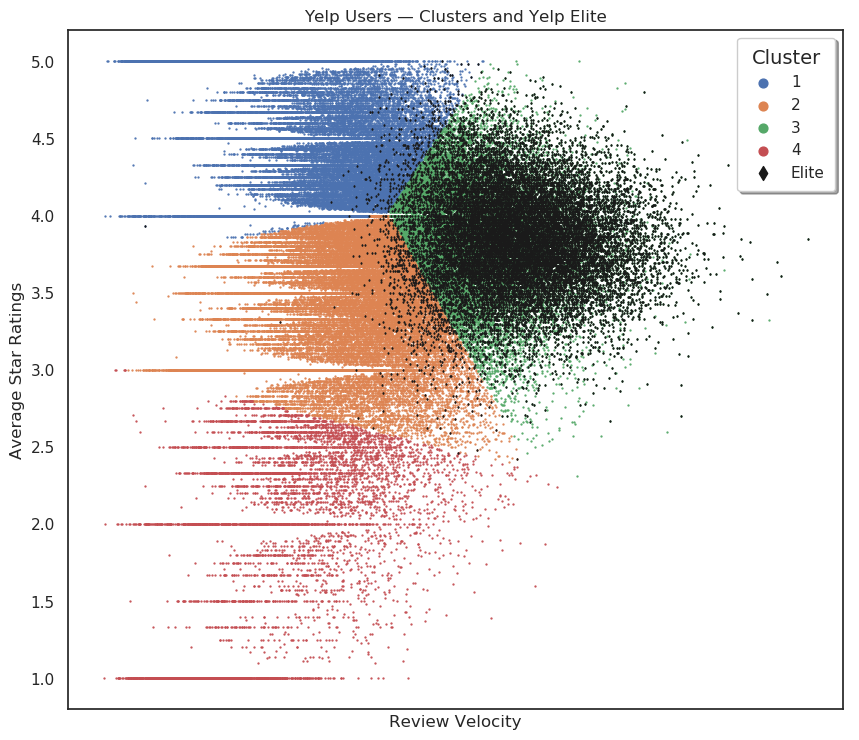

In [35]:
# Graph the clusters and learned centroids
plt.figure(figsize=(10, 9), dpi=100)

cluster_list = list(set(list(users_df['cluster'])))
clusters_grouped = users_df.groupby('cluster')
for cluster in cluster_list:
    cluster_df = clusters_grouped.get_group(cluster)
    plt.scatter(x=cluster_df['review_velocity'], y=cluster_df['average_stars'], c=f'C{cluster}', s=0.4, label=int(cluster)+1)

# Highlight users who are Elite
for cluster in cluster_list:
    cluster_df = clusters_grouped.get_group(cluster)
    elite_df = cluster_df.loc[cluster_df['years_elite'] != 0]
    plt.scatter(x=elite_df['review_velocity'], y=elite_df['average_stars'], c='k', marker='d', s=0.5, label='Elite')
    if cluster == cluster_list[0]:
        plt.legend(title='Cluster', shadow=True, markerscale=10, borderpad=0.7, title_fontsize=14)

plt.xticks([])
plt.xlabel('Review Velocity')
plt.ylabel('Average Star Ratings')
plt.title('Yelp Users — Clusters and Yelp Elite')
plt.show()

Pretty interesting! Almost all of the Yelp Elite members are in one cluster. What does this mean? Let's dig further in the Report section below.
  
This also provides some support for the validity of the clustering. These centroids were learned without knowledge of a user's elite status. Yet, the groupings match our intuitive expectation that Elite members are probably similar to each other, while  distinctly different from some other groups of users. It's cool to see the Elite users all together, and nearly contained in just one cluster. 

## 5.3 Clustering — Sample Percentages

In [36]:
cluster_percent = []
print('Cluster Percentages:\n')
total_samples = len(users_df['cluster'])
for cluster in set(list(users_df['cluster'])):
    cluster_count = users_df['cluster'].value_counts()[cluster]
    sample_percent = (cluster_count / total_samples) * 100
    cluster_percent.append((cluster, sample_percent))
    print(f'\tCluster {cluster+1} = {sample_percent:.2f}%\n')

Cluster Percentages:

	Cluster 1 = 29.62%

	Cluster 2 = 30.04%

	Cluster 3 = 33.94%

	Cluster 4 = 6.40%



## 5.4 Clustering — Cluster Centroids

In [37]:
print('Cluster Centroids:\n')
for cluster in set(list(users_df['cluster'])):
    centroid = centroids[cluster]
    print(f'\tCluster {cluster+1}  —  Review Velocity = {10**centroid[0]:.2f}, Average Stars = {centroid[1]:.2f}\n')

Cluster Centroids:

	Cluster 1  —  Review Velocity = 1.47, Average Stars = 4.51

	Cluster 2  —  Review Velocity = 2.33, Average Stars = 3.41

	Cluster 3  —  Review Velocity = 17.44, Average Stars = 3.86

	Cluster 4  —  Review Velocity = 0.97, Average Stars = 1.98



# Report

This analysis led to an identification of four clusters in the Yelp user community. Based on data-driven and intuitive understandings of these groups, we can name them and describe some average characteristics of each user type. These groups relate to how often a user posts reviews, and the average rating they give in their reviews. 

**"The Angry Reviewer", Centroid @ (0.97 reviews/year, 1.98 stars), 6.40% of sample**
> The Angry Reviewer posts very rarely, and only posts when they have a bad experience. This is a user who doesn't normally write reviews. But, when a business really disappoints or upsets them, they feel inclined to share the story with the community. This group makes up a small percentage of Yelp users, only representing 6% of this sample of 100,000 users.
  
  
**"The Thrilled Reviewer" (1.47 reviews/year, 4.51 stars), 29.62%**
> The Thrilled Reviewer also posts pretty rarely, but they only post when they have a really great experience. This user is likely also having some negative business interactions here and there. But, they don't feel urged to write about them. Instead they get excited to promote a business if they have an especially positive encounter. This group is much larger than the last, with 30% of users.
  
  
**"The Thoughtful Reviewer" (2.33 reviews/year, 3.41 stars), 30.04%**
> The Thoughtful Reviewer posts more often than the only-angry or only-thrilled reviewers, but is also a fairly casual user. They don't post reviews very often, but are more moderate with their stars. These users are probably more thoughtful about their reviews — focusing on assessing degrees of intermediate quality — and are careful not to give extreme scores (1 or 5 stars). This group also makes up 30% of users.
  
  
**"The Power Reviewer" (17.44 reviews/year, 3.86 stars), 33.94%**
> The Power Reviewer takes their Yelp engagement pretty seriously, and enjoys posting reviews regularly (about 1.5 per-month on average). These users are, overall, pretty generous with their stars (the range of average stars for these users is ~3 to ~4.7 stars). This is, surprisingly, the largest group with 34% of the sample. It seems like Yelp has a pretty engaged user base, with a third of their users in the group that posts most often. 
  
  
  
### Thoughts on Yelp Elite
  
Interestingly, the Power Reviewer cluster almost entirely contains the set of Yelp Elite users in the sample (see plot above). Is that just to be expected? It makes sense that if they are Yelp Elite, they have to be active on the platform, and probably only go to good restaurants? 
  
Could this mean that the Power Reviewers introduce inflation to the review system? If Elite membership implies higher ratings; or vice versa, if giving higher ratings could lead a user to gain Elite status. Then Yelp reviews, especially for businesses that have garnered attention from Elite members, may have artificially high ratings. It's as if these users and businesses fall into an echo chamber of only 4- to 5-star reviews and reviewers.
  
This illustrates the desire for active Yelpers to only go to well-reviewed establishments, and add to the piles of good reviews. Are these users just guided by existing, positive scores? And thus, are having relatively few bad experiences? One could argue that this is simply a democratic rating system working properly — a business starts getting noticed, people like it, promote it, it gets more popular, and so on. But what if a business could gain the initial attention through other, perhaps unfair, means? Say a business owner is friends with many Elite members, and gets artificially high ratings from them. This could have a particularly strong effect on the Yelp community, with its largest group of users who may be heavily relying on existing opinion to determine which businesses they visit (and review themselves). 
  

### Clustered Pair Plot

Section 5.1 included a pair plot of features against each other. These were basic scatter plots of unlabeled input data. Let's make the same plot again, but this time color the clusters that our model identified. The two features used for training yielded interesting clustering results. Let's see what the clusters look like when plotting other attributes.

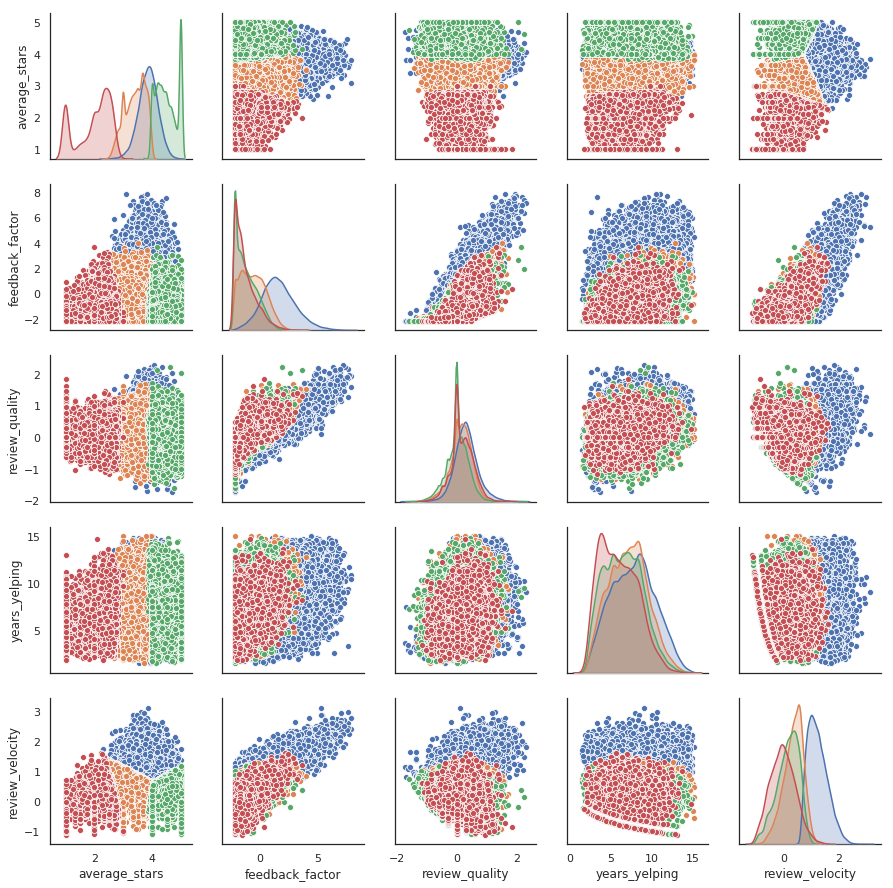

In [39]:
# Plot clusters in order of sample percentage (larger groups first, smallest group last). This is to make sure that the
#    points in the large group don't completely cover the points in the smaller groups.
hue_order = [i[0] for i in sorted(cluster_percent, key=lambda x: x[1], reverse=True)]
interest_cols = ['average_stars', 'feedback_factor', 'review_quality', 'years_yelping', 'review_velocity']
ax = sns.pairplot(users_df, vars=interest_cols, hue='cluster', hue_order=hue_order)
ax._legend.remove()
plt.show()

The four clusters are still visible in some of the attribute pairs, but they don't work well for all of these features. Exploring other attributes could be interesting in future analyses.

The density plot for `average_stars` (top left corner) is also interesting. We can see all four user types arranged horizontally along the axis (representing 1-5 stars). Starting with the Angry Reviewer in red, Thoughful Reviewer in yellow, Power Reviewer in blue, and Thrilled Reviewer in green. The red, yellow and green clusters are not normally-distributed, and even have spikes at the 1- and 5-star ends of the plot. However the blue cluster, the Power Reviewers/Yelp Elite, rate businesses such that their average ratings form a nice, normal distribution. The curve is shifted to the right an entire star rating higher than center. This further illustrates that the most-active, largest group of Yelp reviewers may only bounce around the established, well-reviewed businesses on the platform. These reviewers do give a range of star values, in a way that is statistically expected. But, this range is high (3- to 5-stars on average), and peaks at 4 stars. 